### Preprocess Text Data and Modelling 
### ANLY 590 Project


***

#### Prep

In [0]:
# set working directory
import os
import sys
path = '/Users/kgedney/Documents/georgetown/anly590/author-id-project'
os.chdir(path)

FileNotFoundError: ignored

In [0]:
import numpy as np
import pandas as pd

In [0]:
# load filtered data
df = pd.read_csv('filtered_data.csv')

#### Google Colab Prep

In [0]:
import numpy as np
import pandas as pd

In [0]:
# get data from Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# manually add file from local to drive
df = pd.read_csv('filtered_data.csv')
df.head()

,author,body,subreddit,permalink,num_chars,num_words
0,GuaranteedAdmission,News aggregators don't filter Opinion pieces i...,AskAnAmerican,/r/AskAnAmerican/comments/9zrnid/america_whats...,69,11
1,GuaranteedAdmission,You can be in favor of a policy he supports an...,AskReddit,/r/AskReddit/comments/9zklcs/as_a_brit_who_onl...,74,17
2,GuaranteedAdmission,That depends. What is the penalty for breaking...,AskReddit,/r/AskReddit/comments/9zkfcd/how_would_you_fee...,202,36
3,GuaranteedAdmission,Because I like to think long term. Tax cuts fo...,AskReddit,/r/AskReddit/comments/9yxl98/liberals_of_reddi...,120,22
4,GuaranteedAdmission,"We don't talk about the Highway Shoes, OP! Are...",AskReddit,/r/AskReddit/comments/9yrbvd/people_who_lost_a...,110,22


In [0]:
# download nltk
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

#### Text Cleaning

ref: https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

In [0]:
# remove URLs and replace as '<url>'
import re
df['body_no_urls'] = df.apply(lambda row: re.sub(r"http\S+", "<url>", row['body']), axis=1) 

In [0]:
# tokenize
from nltk.tokenize import word_tokenize
df['tokenized_nltk']  = df.apply(lambda row: word_tokenize(row['body_no_urls']), axis=1)

In [0]:
# remove NERs

In [0]:
# import spacy
# nlp = spacy.load('en')

In [0]:
# def get_ners(input_doc):
#     doc = nlp(input_doc)
#     ners = str(doc.ents)
#     return (ners)

***

#### Modelling

In [0]:
# install packages
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import keras
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, CuDNNLSTM, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D

from keras.layers.core import Dense, Dropout

Using TensorFlow backend.


In [0]:
# create class assignments
df['author_id'] = pd.Categorical(df.author).codes

#### Baseline Model: Linear SVM

In [0]:
x = df['body_no_urls'].values
y = df['author_id'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=22)

tfidf_vec   = TfidfVectorizer()
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec  = tfidf_vec.transform(x_test)
x_train_vec.shape

/Users/kgedney/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(58129, 53161)

In [0]:
from sklearn.svm import LinearSVC
clf             = LinearSVC().fit(x_train_vec, y_train)
predicted       = clf.predict(x_test_vec)
predicted_score = clf.decision_function(x_test_vec)

In [0]:
print('accuracy', metrics.accuracy_score(y_test, predicted))

accuracy 0.37789857565540497


#### Preprocess Data for Keras Models

In [0]:
# data preprocess
x = df['tokenized_nltk'].values
y = df['author_id'].values

# create sequences
max_features = 25000
tokenizer    = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

236


In [0]:
# from keras.utils import to_categorical
# print(y.shape)
# y = to_categorical(y)
# print(y.shape)

(72662,)
(72662, 100)


In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

#### 0. Recurrent Nueral Network: LSTM

In [0]:
model = Sequential()

# add embedding layer
model.add(Embedding(input_dim=max_features,
                    output_dim=128,
                    mask_zero=True))
# add rnn layer
model.add(LSTM(128))
# model.add(Dropout(0.2))

# output layer, 100-categorical classification
model.add(Dense(100, activation="softmax"))

In [0]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
model.fit(x_train, y_train,
            batch_size=128,
            epochs=1,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/1
 4608/58129 [=>............................] - ETA: 3:20 - loss: 4.6005 - acc: 0.0117

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x12af0d9b0>>
Traceback (most recent call last):
  File "/Users/kgedney/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1408, in __del__
    def __del__(self):
KeyboardInterrupt


 5632/58129 [=>............................] - ETA: 3:18 - loss: 4.5987 - acc: 0.0133

KeyboardInterrupt: 

In [0]:
print('accuracy', model.evaluate(x_test, y_test)[1])

In [0]:
(y_train == 57).mean() # guess majority class baseline

0.012558275559531387

In [0]:
# keras.metrics.top_k_categorical_accuracy(y_test, predicted, k=5)

#### 1. Faster RNN Model: CuDNNLSTM 

- Run on Google Colab, 14 mins.    
- Very overfit

In [0]:
# ref: https://keras.io/layers/recurrent/#cudnnlstm
# faster LSTM implementation

model1 = Sequential()
model1.add(Embedding(input_dim=max_features,
                     output_dim=128))
model1.add(CuDNNLSTM(128))
model1.add(Dropout(0.5))
model1.add(Dense(100, activation="softmax"))

model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
history1 = model1.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 28s 478us/step - loss: 4.1751 - acc: 0.0600 - val_loss: 4.0011 - val_acc: 0.0813
Epoch 2/16
58129/58129 [==============================] - 28s 474us/step - loss: 3.8129 - acc: 0.1118 - val_loss: 3.7776 - val_acc: 0.1312
Epoch 3/16
58129/58129 [==============================] - 28s 474us/step - loss: 3.4309 - acc: 0.1815 - val_loss: 3.6797 - val_acc: 0.1569
Epoch 4/16
58129/58129 [==============================] - 28s 476us/step - loss: 3.0639 - acc: 0.2570 - val_loss: 3.5808 - val_acc: 0.1903
Epoch 5/16
58129/58129 [==============================] - 28s 478us/step - loss: 2.6972 - acc: 0.3375 - val_loss: 3.5613 - val_acc: 0.2191
Epoch 6/16
58129/58129 [==============================] - 28s 481us/step - loss: 2.3518 - acc: 0.4208 - val_loss: 3.5730 - val_acc: 0.2314
Epoch 7/16
58129/58129 [==============================] - 28s 479us/step - loss: 2.0401 - acc: 0.4960 - val_loss: 3.

In [0]:
print('accuracy', model1.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 7s 449us/step
accuracy 0.2425514346659327


In [0]:
print('accuracy', model1.evaluate(x_train, y_train)[1])

58129/58129 [==============================] - 25s 427us/step
accuracy 0.9214849730801977


#### 2. Bidirectional

- Also overfits 

In [0]:
# Bidirectional
model2 = Sequential()
model2.add(Embedding(input_dim=max_features,
                     output_dim=128))

model2.add(Bidirectional(CuDNNLSTM(128)))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation="softmax"))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
history2 = model2.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 51s 885us/step - loss: 4.3861 - acc: 0.0376 - val_loss: 4.1800 - val_acc: 0.0564
Epoch 2/16
58129/58129 [==============================] - 51s 870us/step - loss: 4.0185 - acc: 0.0777 - val_loss: 3.9345 - val_acc: 0.0977
Epoch 3/16
58129/58129 [==============================] - 51s 872us/step - loss: 3.6703 - acc: 0.1319 - val_loss: 3.7773 - val_acc: 0.1301
Epoch 4/16
58129/58129 [==============================] - 51s 871us/step - loss: 3.3328 - acc: 0.1960 - val_loss: 3.6396 - val_acc: 0.1686
Epoch 5/16
58129/58129 [==============================] - 50s 866us/step - loss: 2.9899 - acc: 0.2714 - val_loss: 3.5972 - val_acc: 0.1881
Epoch 6/16
58129/58129 [==============================] - 51s 870us/step - loss: 2.6527 - acc: 0.3420 - val_loss: 3.6188 - val_acc: 0.2090
Epoch 7/16
58129/58129 [==============================] - 50s 868us/step - loss: 2.3577 - acc: 0.4141 - val_loss: 3.

In [0]:
print('accuracy', model2.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 11s 758us/step
accuracy 0.2401431225486823


#### 3. Simple Pooling Model

In [0]:
#ref: https://github.com/keras-team/keras/blob/master/examples/imdb_fasttext.py

In [0]:
model3 = Sequential()
model3.add(Embedding(input_dim=max_features,
                    output_dim=128))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model3.add(GlobalAveragePooling1D())
model3.add(Dropout(0.5))

model3.add(Dense(100, activation="softmax"))

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
history3 = model3.fit(x_train, y_train,
            batch_size=256,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 3s 57us/step - loss: 4.4614 - acc: 0.0423 - val_loss: 4.2416 - val_acc: 0.0908
Epoch 2/16
58129/58129 [==============================] - 3s 45us/step - loss: 3.9859 - acc: 0.1360 - val_loss: 3.7676 - val_acc: 0.1842
Epoch 3/16
58129/58129 [==============================] - 3s 45us/step - loss: 3.5087 - acc: 0.2306 - val_loss: 3.4221 - val_acc: 0.2571
Epoch 4/16
58129/58129 [==============================] - 3s 45us/step - loss: 3.1174 - acc: 0.3118 - val_loss: 3.1659 - val_acc: 0.3058
Epoch 5/16
58129/58129 [==============================] - 3s 45us/step - loss: 2.7843 - acc: 0.3846 - val_loss: 2.9862 - val_acc: 0.3374
Epoch 6/16
58129/58129 [==============================] - 3s 46us/step - loss: 2.5091 - acc: 0.4449 - val_loss: 2.8559 - val_acc: 0.3663
Epoch 7/16
58129/58129 [==============================] - 3s 46us/step - loss: 2.2611 - acc: 0.4998 - val_loss: 2.7582 - val_acc

In [0]:
print('accuracy', model3.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 1s 57us/step
accuracy 0.41904630840156887


#### Plots + Compare Models

In [0]:
import matplotlib.pyplot as plt

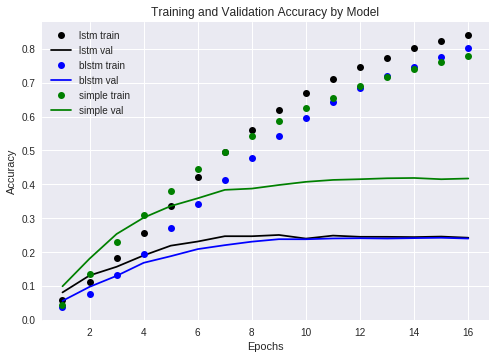

In [0]:
# plot test vs. train to show overfitting!

# Get values 
acc1     = history1.history['acc']
val_acc1 = history1.history['val_acc']

acc2     = history2.history['acc']
val_acc2 = history2.history['val_acc']

acc3     = history3.history['acc']
val_acc3 = history3.history['val_acc']


# Setup grid for plotting
epochs = range(1, len(acc) + 1)

# plot model 1
plt.plot(epochs, acc1, 'bo', label='lstm train', color='k')
plt.plot(epochs, val_acc1, 'b', label='lstm val', color='k')

# plot model 2
plt.plot(epochs, acc2, 'bo', label='blstm train', color='b')
plt.plot(epochs, val_acc2, 'b', label='blstm val', color='b')

# plot model 3
plt.plot(epochs, acc3, 'bo', label='simple train', color='g')
plt.plot(epochs, val_acc3, 'b', label='simple val', color='g')

plt.title('Training and Validation Accuracy by Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# plot accuracy rates by author from best model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

y_pred = model3.predict_classes(x_test)
# print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred) #only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies = cm.diagonal()

In [0]:
test_scores = model3.predict(x_test) # basically the softmax output

In [0]:
def topk_acc(y_test, y_pred, k):
  return keras.backend.eval(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred, k=k)) # force it to evaluate

[(k, topk_acc(y_test, test_scores, k=k)) for k in range(1, 10)]

[(1, 0.4190463),
 (2, 0.51826876),
 (3, 0.5746233),
 (4, 0.6150141),
 (5, 0.6444643),
 (6, 0.6697172),
 (7, 0.6920801),
 (8, 0.71134657),
 (9, 0.7271038)]

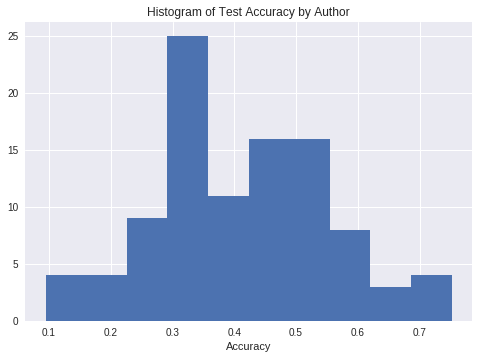

In [0]:
plt.hist(accuracies, bins=10)
plt.title('Histogram of Test Accuracy by Author')
plt.xlabel('Accuracy')
plt.show()

In [0]:
# lots of politics, and very consistent writing style
print(accuracies.max())
print(accuracies.argmax())
print(df[['author', 'body']][df['author_id'] == 68][0:5])

0.7517241379310344
68
      author                                               body
9346  djphan  Kansas is an underrated pickup opportunity... ...
9347  djphan  how can i point to their argument without usin...
9348  djphan  i did.. i see the subsequent comments... and t...
9349  djphan  i literally quoted it in my first reply...  \n...
9350  djphan  youre saying that clinton did it herself... th...


#### Save Models

In [0]:
model1.save('/content/gdrive/My Drive/colab/anly-author-id/model_l.h5')
model2.save('/content/gdrive/My Drive/colab/anly-author-id/model_2.h5')
model3.save('/content/gdrive/My Drive/colab/anly-author-id/model_3.h5')

#### EXTRA. Multilayer

In [0]:
# Multilayer LSTM
model5 = Sequential()
model5.add(Embedding(input_dim=max_features,
                    output_dim=128))

model5.add(CuDNNLSTM(128, return_sequences=True))
model5.add(Dropout(0.5))

model5.add(CuDNNLSTM(64))
model5.add(Dropout(0.5))

model5.add(Dense(100, activation="softmax"))

model5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
history5 = model5.fit(x_train, y_train,
            batch_size=256,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 46s 797us/step - loss: 4.4563 - acc: 0.0301 - val_loss: 4.2198 - val_acc: 0.0588
Epoch 2/16
58129/58129 [==============================] - 44s 764us/step - loss: 4.1062 - acc: 0.0710 - val_loss: 3.9898 - val_acc: 0.0962
Epoch 3/16
58129/58129 [==============================] - 44s 756us/step - loss: 3.8289 - acc: 0.1135 - val_loss: 3.7824 - val_acc: 0.1303
Epoch 4/16
58129/58129 [==============================] - 44s 765us/step - loss: 3.6063 - acc: 0.1513 - val_loss: 3.6834 - val_acc: 0.1494
Epoch 5/16
58129/58129 [==============================] - 44s 761us/step - loss: 3.4146 - acc: 0.1893 - val_loss: 3.6164 - val_acc: 0.1682
Epoch 6/16
58129/58129 [==============================] - 44s 753us/step - loss: 3.2467 - acc: 0.2262 - val_loss: 3.5665 - val_acc: 0.1844
Epoch 7/16
58129/58129 [==============================] - 44s 754us/step - loss: 3.0894 - acc: 0.2571 - val_loss: 3.

In [0]:
print('accuracy', model4.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 13s 883us/step
accuracy 0.22183995045860463
